<a href="https://colab.research.google.com/github/rllima/IF704/blob/main/Classification_step.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np

In [3]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf
from google.colab import drive

In [4]:
##Metrics functions
#Metrics have been removed from Keras core. You need to calculate them manually. 
#They removed them on 2.0 version. Those metrics are all global metrics, but Keras works in batches. As a result, it might be more misleading than helpful.

from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:
!apt install unzip

Reading package lists... Done
Building dependency tree       
Reading state information... Done
unzip is already the newest version (6.0-21ubuntu1.1).
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.


In [5]:
drive.mount('/content/drive/',force_remount=True)

Mounted at /content/drive/


In [6]:
#Download do dataset
import requests, zipfile, io
r = requests.get("http://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip")
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall("/content/drive/My Drive/IF704")
z.close()

In [ ]:
!ls "/content/drive/My Drive/IF704/"

testdata.manual.2009.06.14.csv	training.1600000.processed.noemoticon.csv


In [7]:
df = pd.read_csv("/content/drive/My Drive/IF704/training.1600000.processed.noemoticon.csv",
                 names = ["target","id","date","query","user","text"], header=None, encoding='latin-1')

In [8]:
df.head()

,target,id,date,query,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [9]:
df.dtypes

target     int64
id         int64
date      object
query     object
user      object
text      object
dtype: object

In [ ]:
df.target.unique()

array([0, 4])

In [10]:
df.target = df.target.replace(to_replace=4,value=1)

In [11]:
df.target.unique()

array([0, 1])

Transformaçãp do formato pandas para Ts

In [12]:
target = df.pop('target')

In [13]:
dataset = tf.data.Dataset.from_tensor_slices((df.text.values, target.values))

In [14]:
for feat, targ in dataset.take(5):
  print ('Features: {}, Target: {}'.format(feat, targ))

Features: b"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D", Target: 0
Features: b"is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!", Target: 0
Features: b'@Kenichan I dived many times for the ball. Managed to save 50%  The rest go out of bounds', Target: 0
Features: b'my whole body feels itchy and like its on fire ', Target: 0
Features: b"@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there. ", Target: 0


In [15]:
DATASET_SIZE = df.shape[0]

In [16]:
train_size = int(0.8 * DATASET_SIZE)
test_size = int(0.2 * DATASET_SIZE)
train_dataset = dataset.take(train_size)
test_dataset = dataset.skip(train_size)
test_dataset = test_dataset.take(test_size)

In [ ]:
from collections import Counter
results = Counter()
df['text'].str.lower().str.split().apply(results.update)
print(len(results))

1193584


In [17]:
BUFFER_SIZE = 10000
BATCH_SIZE = 128

In [18]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [19]:
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [20]:
VOCAB_SIZE = 10000
encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

In [21]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'i', 'to', 'the', 'a', 'my', 'and', 'you', 'is', 'it',
       'in', 'for', 'of', 'im', 'on', 'me', 'so', 'have', 'that'],
      dtype='<U27')

In [22]:
encoded_example = encoder("I like so much")[:3].numpy()
encoded_example

array([ 2, 37, 17])

In [23]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [24]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


In [25]:
# predict on a sample text without padding.

sample_text = ('The movie was cool')
sample_text2 = ('The movie was bad :(')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])
predictions = model.predict(np.array([sample_text2]))
print(predictions[0])


[-0.00324312]
[-0.004762]


In [26]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(0.0001),
              metrics=['accuracy',f1_m])

Traning Model

In [27]:
history = model.fit(train_dataset, epochs=5,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/5
10000/10000 [==============================] - 216s 21ms/step - loss: 0.0492 - accuracy: 0.9918 - f1_m: 0.3694 - val_loss: 2.7410e-04 - val_accuracy: 1.0000 - val_f1_m: 1.0000
Epoch 2/5
10000/10000 [==============================] - 211s 21ms/step - loss: 0.0541 - accuracy: 0.9871 - f1_m: 0.3724 - val_loss: 1.7522e-04 - val_accuracy: 1.0000 - val_f1_m: 1.0000
Epoch 3/5
10000/10000 [==============================] - 211s 21ms/step - loss: 0.0394 - accuracy: 0.9909 - f1_m: 0.3736 - val_loss: 1.2591e-04 - val_accuracy: 1.0000 - val_f1_m: 1.0000
Epoch 4/5
10000/10000 [==============================] - 207s 21ms/step - loss: 0.0277 - accuracy: 0.9924 - f1_m: 0.3738 - val_loss: 9.5447e-05 - val_accuracy: 1.0000 - val_f1_m: 1.0000
Epoch 5/5
10000/10000 [==============================] - 208s 21ms/step - loss: 0.0239 - accuracy: 0.9933 - f1_m: 0.3744 - val_loss: 6.1316e-05 - val_accuracy: 1.0000 - val_f1_m: 1.0000


In [29]:
test_loss, test_acc, test_f1 = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)
print('Test F1:', test_f1)

2500/2500 [==============================] - 18s 7ms/step - loss: 8.7488e-05 - accuracy: 1.0000 - f1_m: 1.0000
Test Loss: 8.748838445171714e-05
Test Accuracy: 0.9999812245368958
Test F1: 0.9999906420707703


In [30]:
import matplotlib.pyplot as plt


def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

(0.0, 0.05677744721688214)

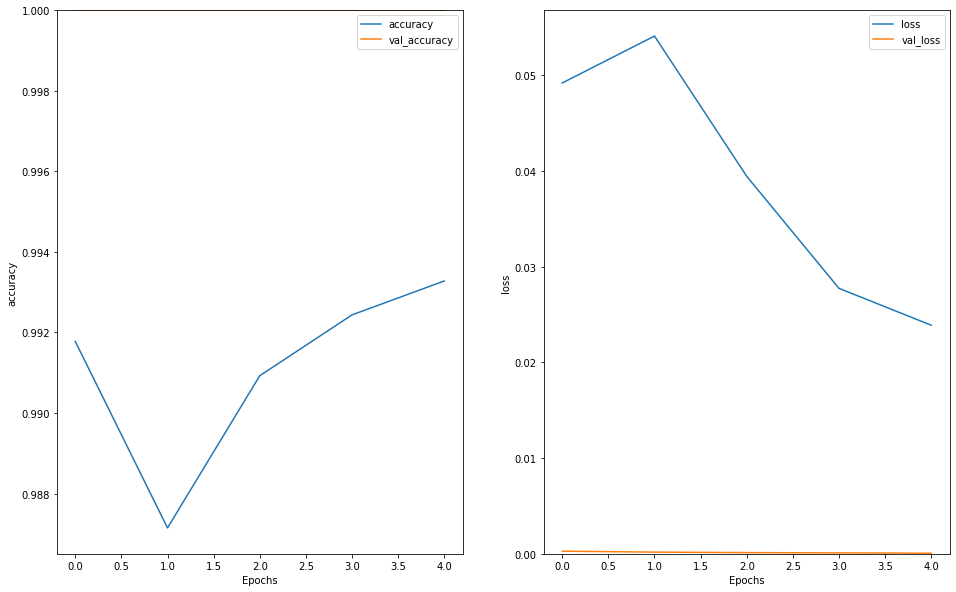

In [39]:
plt.figure(figsize=(16, 10))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)


In [ ]:
##Second configuration

In [42]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [43]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(0.00001),
              metrics=['accuracy',f1_m])

In [44]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
10000/10000 [==============================] - 329s 31ms/step - loss: 0.4754 - accuracy: 0.7371 - f1_m: 0.1246 - val_loss: 0.1333 - val_accuracy: 0.9932 - val_f1_m: 0.9966
Epoch 2/10
10000/10000 [==============================] - 317s 32ms/step - loss: 0.5402 - accuracy: 0.7400 - f1_m: 0.1749 - val_loss: 0.0469 - val_accuracy: 0.9979 - val_f1_m: 0.9990
Epoch 3/10
10000/10000 [==============================] - 313s 31ms/step - loss: 0.2812 - accuracy: 0.9022 - f1_m: 0.3299 - val_loss: 0.0181 - val_accuracy: 1.0000 - val_f1_m: 1.0000
Epoch 4/10
10000/10000 [==============================] - 312s 31ms/step - loss: 0.1794 - accuracy: 0.9494 - f1_m: 0.3594 - val_loss: 0.0087 - val_accuracy: 0.9997 - val_f1_m: 0.9999
Epoch 5/10
10000/10000 [==============================] - 312s 31ms/step - loss: 0.1154 - accuracy: 0.9729 - f1_m: 0.3686 - val_loss: 0.0049 - val_accuracy: 0.9997 - val_f1_m: 0.9999
Epoch 6/10
10000/10000 [==============================] - 310s 31ms/step - loss: 0.08

In [45]:
test_loss, test_acc, test_f1 = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)
print('Test F1:', test_f1)

2500/2500 [==============================] - 24s 9ms/step - loss: 0.0011 - accuracy: 0.9998 - f1_m: 0.9999
Test Loss: 0.0010660949628800154
Test Accuracy: 0.9998499751091003
Test F1: 0.999924898147583


In [46]:
# predict on a sample text without padding.

sample_text = ('The movie was not good. The animation and the graphics '
               'were terrible. I would not recommend this movie.')
sample_text2 = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
predictions2 = model.predict(np.array([sample_text2]))
print(predictions,predictions2)

[[11.685175]] [[11.08738]]


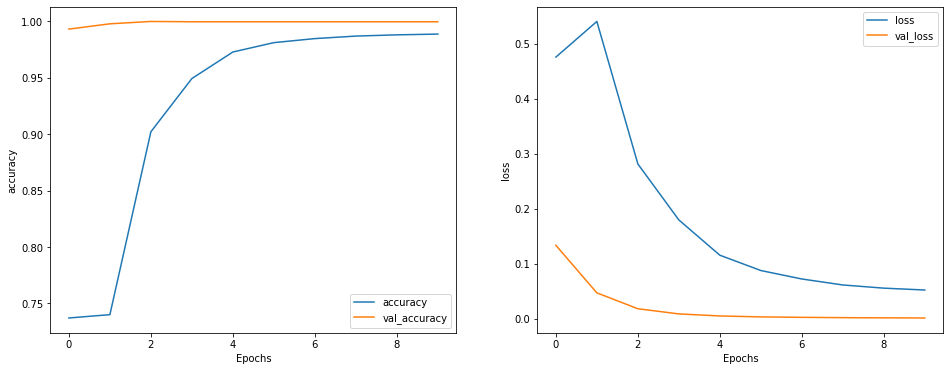

In [47]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')